In [93]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import copy
import pickle


In [142]:
def load_images_as_bw_matrices(directory):
    image_matrices = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        # Check if it's a valid file
        if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.JPG')):
            try:
                # Open the image
                with Image.open(filepath) as img:
                    # Convert to black and white
                    bw_img = img.convert('L')
                    # Convert to a numpy array (matrix)
                    matrix = np.array(bw_img)
                    # Append the matrix to the list
                    image_matrices.append(matrix)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    
    return image_matrices

In [143]:
# Display the nth image in the list
def show_image(image_matrices, n):
    if image_matrices:
        plt.imshow(image_matrices[n], cmap='gray')
        plt.title(f"Image {n}")
        plt.axis('off')  # Turn off axis labels
        plt.show()
    else:
        print("The list of image matrices is empty!")

In [144]:
clean = load_images_as_bw_matrices('data/train/clean')
dirty = load_images_as_bw_matrices('data/train/dirty')
combined = clean + dirty

# Output the number of processed images
print(f"Processed {len(clean)} images for clean plates")
print(f"Processed {len(dirty)} images for dirty plates")

Processed 290 images for clean plates
Processed 502 images for dirty plates


In [146]:
# Display all images in a grid, resized to small thumbnails
def show_some_images(image_matrices, max_cols=5, thumbnail_size=(64, 64), num=20):
    if not image_matrices:
        print("The list of image matrices is empty!")
        return

    if len(image_matrices) < num:
        num = len(image_matrices)

    images = image_matrices[:num]
    
    # Calculate grid dimensions
    num_images = len(images)
    rows = (num_images + max_cols - 1) // max_cols  # Ceiling division for rows
    
    # Create figure
    fig, axes = plt.subplots(rows, max_cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten to 1D for easy iteration

    for idx, matrix in enumerate(images):
        # Resize matrix for smaller display (optional)
        thumbnail = matrix[::matrix.shape[0] // thumbnail_size[0] or 1, ::matrix.shape[1] // thumbnail_size[1] or 1]
        
        axes[idx].imshow(thumbnail, cmap = 'gray')
        axes[idx].axis('off')  # Turn off axis labels
    
    # Hide any unused axes
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

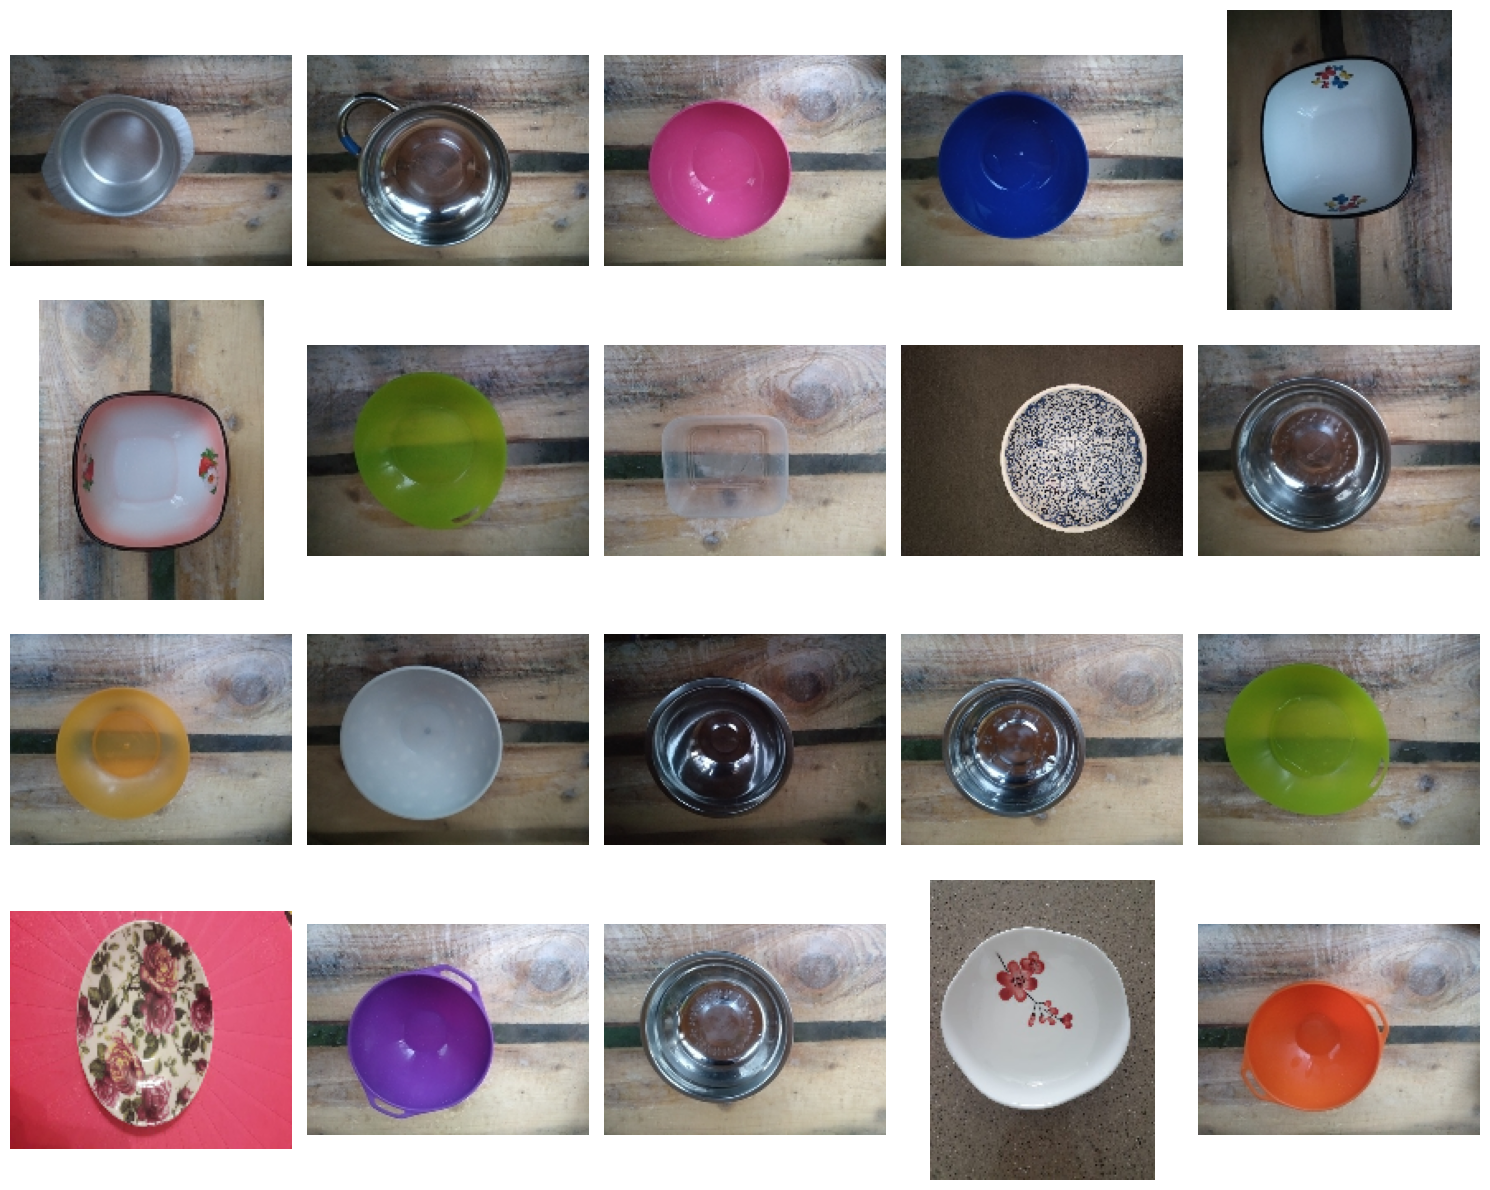

In [137]:
show_some_images(clean, max_cols=5, thumbnail_size=(128, 128))

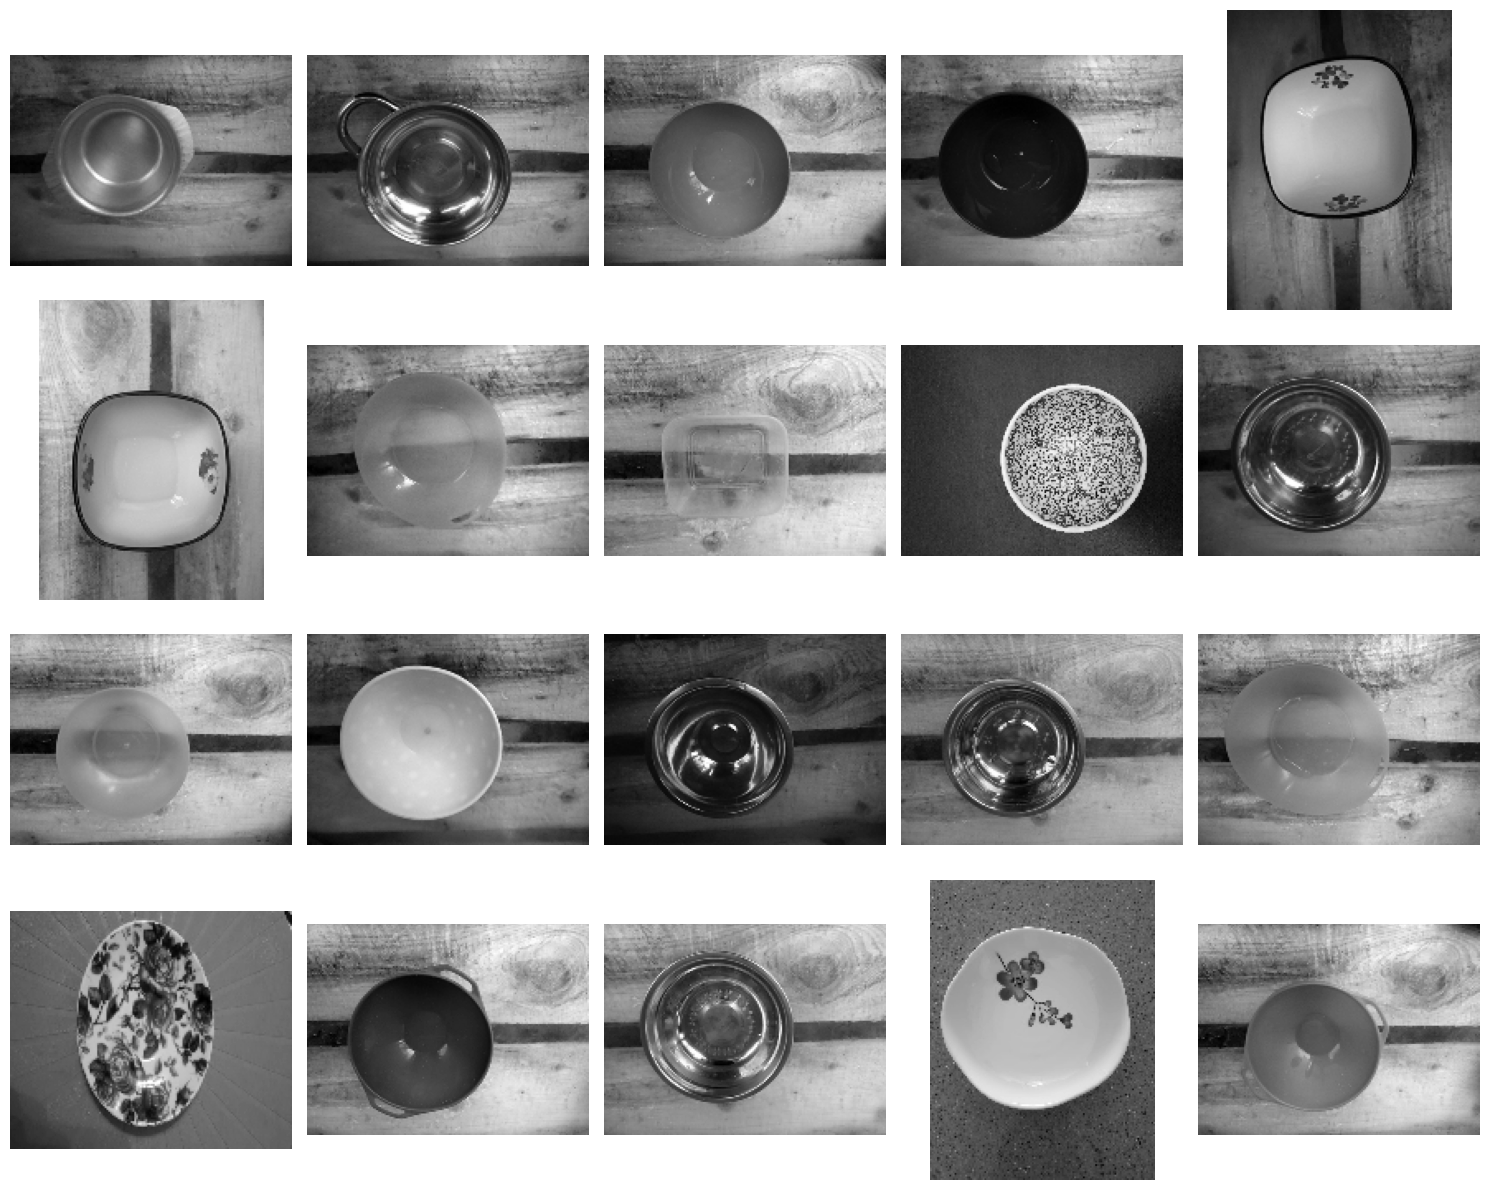

In [148]:
show_some_images(combined, max_cols=5, thumbnail_size=(128, 128))

In [100]:
def resize_images_to_average(images):
    """
    Resizes a list of image arrays to the average size by cropping or padding.

    Args:
        images (list): List of image matrices (NumPy arrays).

    Returns:
        list: List of resized image matrices.
    """
    # Calculate average dimensions
    avg_height = int(np.mean([img.shape[0] for img in images]))
    avg_width = int(np.mean([img.shape[1] for img in images]))
    target_size = (avg_height, avg_width)
    
    resized_images = []
    for img in images:
        resized_img = resize_image(img, target_size)
        resized_images.append(resized_img)
    
    return resized_images

def resize_image(image, target_size):
    """
    Resizes a single image to target size by cropping or padding.

    Args:
        image (np.ndarray): Image matrix.
        target_size (tuple): Target size as (height, width).

    Returns:
        np.ndarray: Resized image matrix.
    """
    target_height, target_width = target_size
    height, width = image.shape[:2]
    
    # Initialize the new image with zeros (black padding)
    if image.ndim == 3:  # Color image
        resized_image = np.zeros((target_height, target_width, image.shape[2]), dtype=image.dtype)
    else:  # Grayscale image
        resized_image = np.zeros((target_height, target_width), dtype=image.dtype)

    # Calculate cropping or padding indices
    crop_top = max(0, (height - target_height) // 2)
    crop_bottom = min(height, crop_top + target_height)
    crop_left = max(0, (width - target_width) // 2)
    crop_right = min(width, crop_left + target_width)

    pad_top = max(0, (target_height - height) // 2)
    pad_bottom = pad_top + (crop_bottom - crop_top)
    pad_left = max(0, (target_width - width) // 2)
    pad_right = pad_left + (crop_right - crop_left)

    # Copy the cropped portion into the padded target array
    resized_image[pad_top:pad_bottom, pad_left:pad_right] = image[crop_top:crop_bottom, crop_left:crop_right]

    return resized_image


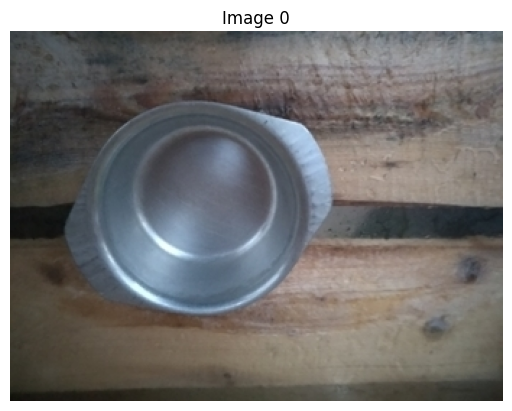

In [101]:
# Example image
show_image(combined, 0)

In [150]:
resized_data = resize_images_to_average(combined)

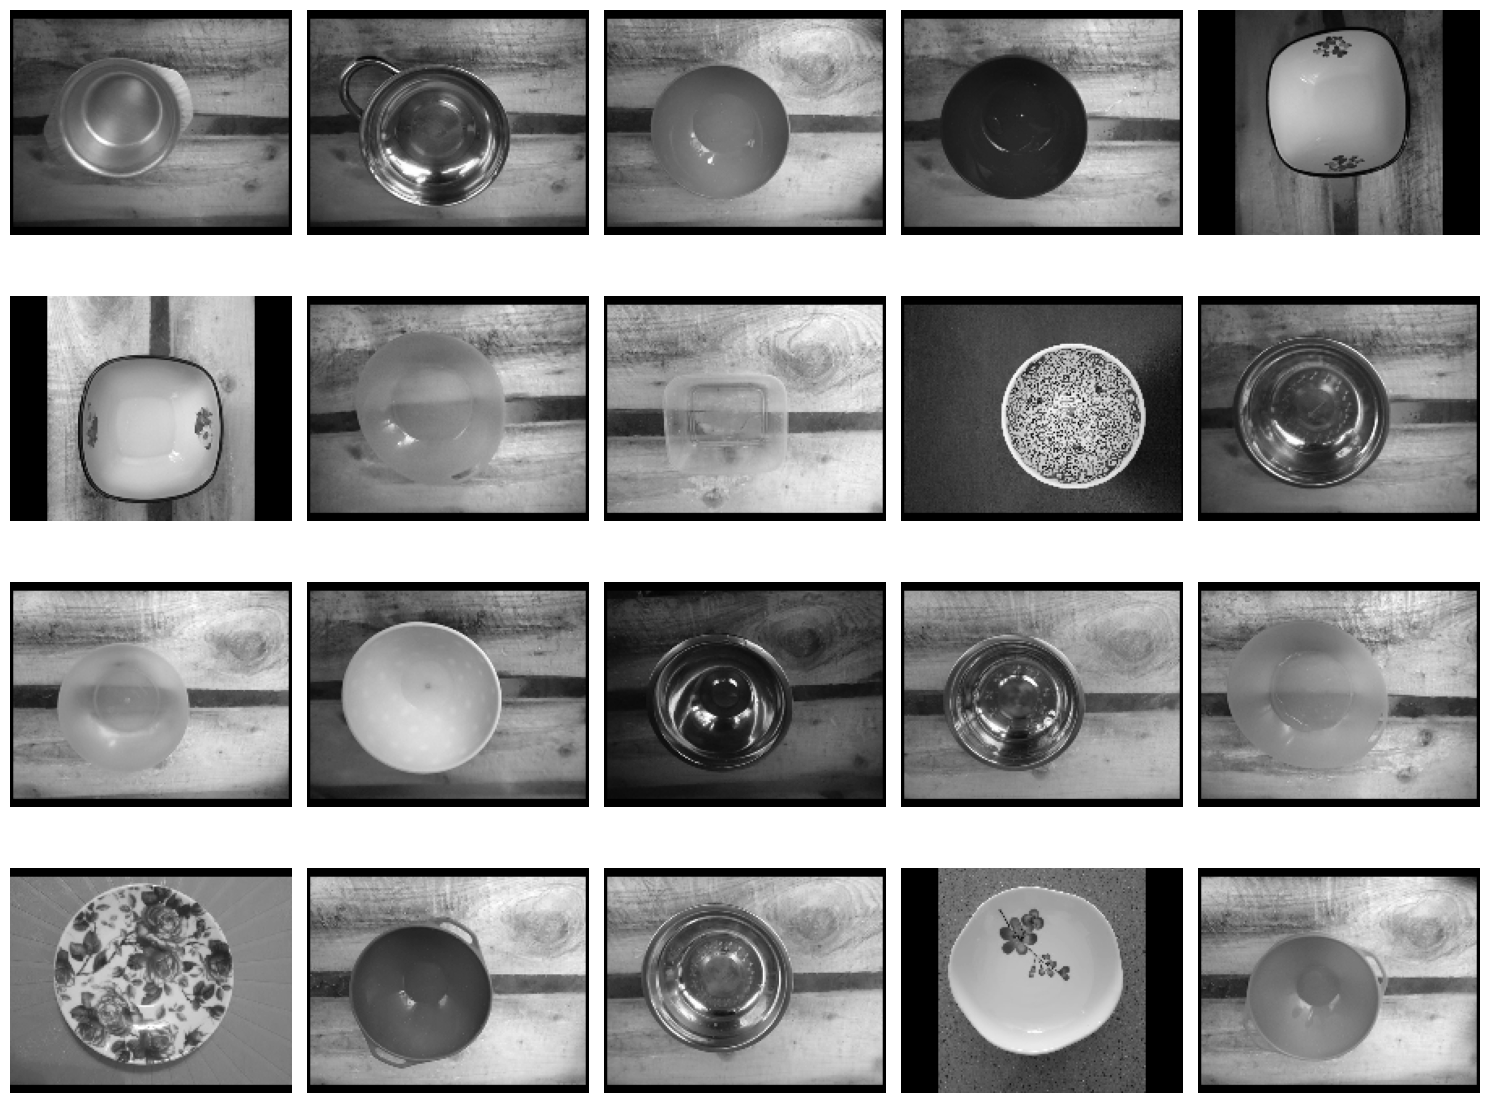

In [151]:
show_some_images(resized_data, max_cols=5, thumbnail_size=(128, 128))

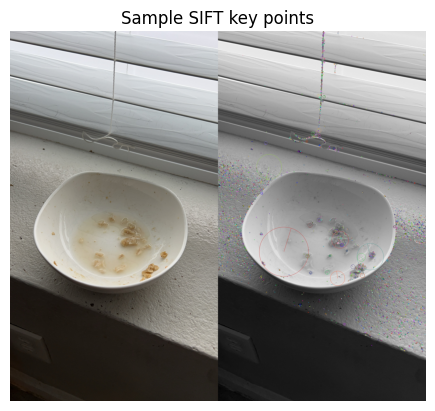

In [104]:
img = cv.imread('data/train/dirty/IMG_2072.JPG')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
cv.imwrite('data/analysis/sample.jpg',img)
 
img=cv.drawKeypoints(gray,kp,img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
cv.imwrite('data/analysis/sample_SIFT.jpg',img)


# This is only to display the results on the notebook

# Read the images
image1 = mpimg.imread('data/analysis/sample.jpg') 
image2 = mpimg.imread('data/analysis/sample_SIFT.jpg')

# Combine the images horizontally
combined_image = np.hstack((image1, image2))

# Display the combined image
plt.imshow(combined_image)
plt.axis('off')  # Hide axes
plt.title("Sample SIFT key points")
plt.show()

In [105]:
# apply SIFT to every image to get our dataset
# every image transformed: a matrix of pixel values -> a list of 2 lists, keypoints and descriptors
X = []
for image in resized_data:
    gray= cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    X.append([kp, des])


In [106]:
def head(lst, n):
    return lst[:n]

def tail(lst, n):
    return lst[-n:]

In [126]:
print(f"Length of X: {len(X)}")
print(f"Length of X[0]: {len(X[0])}")

num_clean = int(len(clean)) 
num_dirty = int(len(dirty))

# create our y for our data
Y = list(np.zeros(num_clean, dtype=int)) + list(np.ones(num_dirty, dtype=int))

# 0 = clean
# 1 = dirty

# np ints will be casted to native ints when needed
print(f"head(X): {head(X, 5)}")
print(f"head(Y): {head(Y, 10)}")
print(f"tail(Y): {tail(Y, 10)}")

Length of X: 788
Length of X[0]: 2
head(X): [[(< cv2.KeyPoint 0x1110429d0>, < cv2.KeyPoint 0x111040510>, < cv2.KeyPoint 0x13bd1b6f0>, < cv2.KeyPoint 0x117ce03c0>, < cv2.KeyPoint 0x117ce2d00>, < cv2.KeyPoint 0x117ce22e0>, < cv2.KeyPoint 0x117ce2fd0>, < cv2.KeyPoint 0x117ce0120>, < cv2.KeyPoint 0x11175f2d0>, < cv2.KeyPoint 0x11816fc90>, < cv2.KeyPoint 0x11816fb40>, < cv2.KeyPoint 0x11816fba0>, < cv2.KeyPoint 0x11816fcc0>, < cv2.KeyPoint 0x11816fe10>, < cv2.KeyPoint 0x11816fe70>, < cv2.KeyPoint 0x11816f960>, < cv2.KeyPoint 0x11816fa20>, < cv2.KeyPoint 0x11816f990>, < cv2.KeyPoint 0x11816fd20>, < cv2.KeyPoint 0x11816fd50>, < cv2.KeyPoint 0x11816f9f0>, < cv2.KeyPoint 0x129a9e220>, < cv2.KeyPoint 0x129a9ddd0>, < cv2.KeyPoint 0x111407f00>, < cv2.KeyPoint 0x108f15f50>, < cv2.KeyPoint 0x108f16220>, < cv2.KeyPoint 0x108f15c80>, < cv2.KeyPoint 0x1109244e0>, < cv2.KeyPoint 0x1109248a0>, < cv2.KeyPoint 0x110924930>, < cv2.KeyPoint 0x1109243c0>, < cv2.KeyPoint 0x110924bd0>, < cv2.KeyPoint 0x11092484

In [108]:
# lets check how many keypoints and descriptors each image has

nones = []

for index, i in enumerate(X):
    if i[1] is not None:
        print(f"{len(i[0])} {len(i[1])}")
    else:
        print("image at index {index} has no keypoints")
        nones.append(index)

216 216
380 380
295 295
320 320
185 185
153 153
158 158
291 291
658 658
447 447
194 194
145 145
182 182
396 396
248 248
877 877
306 306
391 391
199 199
219 219
126 126
445 445
136 136
441 441
238 238
318 318
335 335
234 234
238 238
68 68
200 200
326 326
278 278
294 294
361 361
141 141
274 274
262 262
325 325
224 224
857 857
250 250
251 251
162 162
107 107
289 289
162 162
351 351
179 179
369 369
406 406
394 394
170 170
508 508
145 145
691 691
554 554
293 293
284 284
301 301
172 172
242 242
209 209
217 217
465 465
381 381
422 422
393 393
313 313
196 196
399 399
308 308
347 347
874 874
44 44
167 167
271 271
306 306
259 259
121 121
430 430
226 226
352 352
374 374
473 473
32 32
283 283
52 52
547 547
691 691
824 824
156 156
109 109
218 218
257 257
image at index {index} has no keypoints
345 345
118 118
106 106
243 243
281 281
41 41
35 35
3 3
444 444
71 71
269 269
111 111
606 606
331 331
290 290
357 357
560 560
438 438
335 335
279 279
60 60
288 288
186 186
34 34
155 155
233 233
252 252
152 15

In [109]:
# some descriptors are None, let's see they're matching keypoints
print(nones)
print(X[96][0])
print(X[131][0])
print(X[180][0])

# empty, as expected

[95, 130, 179]
(< cv2.KeyPoint 0x110833810>, < cv2.KeyPoint 0x110833840>, < cv2.KeyPoint 0x110833870>, < cv2.KeyPoint 0x1108338a0>, < cv2.KeyPoint 0x1108338d0>, < cv2.KeyPoint 0x110833900>, < cv2.KeyPoint 0x110833930>, < cv2.KeyPoint 0x110833960>, < cv2.KeyPoint 0x110833990>, < cv2.KeyPoint 0x1108339c0>, < cv2.KeyPoint 0x1108339f0>, < cv2.KeyPoint 0x110833a20>, < cv2.KeyPoint 0x110833a50>, < cv2.KeyPoint 0x110833a80>, < cv2.KeyPoint 0x110833ab0>, < cv2.KeyPoint 0x110833ae0>, < cv2.KeyPoint 0x110833b10>, < cv2.KeyPoint 0x110833b40>, < cv2.KeyPoint 0x110833b70>, < cv2.KeyPoint 0x110833ba0>, < cv2.KeyPoint 0x110833bd0>, < cv2.KeyPoint 0x110833c00>, < cv2.KeyPoint 0x110833c30>, < cv2.KeyPoint 0x110833c60>, < cv2.KeyPoint 0x110833c90>, < cv2.KeyPoint 0x110833cc0>, < cv2.KeyPoint 0x110833cf0>, < cv2.KeyPoint 0x110833d20>, < cv2.KeyPoint 0x110833d50>, < cv2.KeyPoint 0x110833d80>, < cv2.KeyPoint 0x110833db0>, < cv2.KeyPoint 0x110833de0>, < cv2.KeyPoint 0x110833e10>, < cv2.KeyPoint 0x110833e40>

In [110]:
# Let's get a count of all the different number of keypoints among our datapoints

def keypoint_count(data):
    shapes = []
    outliers = []

    for index, i in enumerate(data):
        if i[1] is None:
            shapes.append(0)
            outliers.append(index)
            
        else:
            shapes.append(len(i[1]))

            if len(i[1]) <= 3:
                outliers.append(index)
            
            assert(len(i[1]) == len(i[0]))

    # Count unique values
    unique_values, counts = np.unique(np.array(shapes), return_counts=True)

    # Print results
    for value, count in zip(unique_values, counts):
        print(f"Value: {value}, Count: {count}")

    return shapes, outliers

shapes, outliers = keypoint_count(X)

Value: 0, Count: 3
Value: 3, Count: 1
Value: 12, Count: 2
Value: 21, Count: 1
Value: 24, Count: 1
Value: 32, Count: 1
Value: 34, Count: 1
Value: 35, Count: 1
Value: 37, Count: 1
Value: 39, Count: 1
Value: 41, Count: 1
Value: 44, Count: 1
Value: 46, Count: 1
Value: 52, Count: 2
Value: 60, Count: 1
Value: 64, Count: 1
Value: 67, Count: 1
Value: 68, Count: 1
Value: 69, Count: 1
Value: 71, Count: 1
Value: 86, Count: 2
Value: 87, Count: 1
Value: 89, Count: 1
Value: 90, Count: 1
Value: 95, Count: 1
Value: 101, Count: 1
Value: 106, Count: 2
Value: 107, Count: 2
Value: 109, Count: 1
Value: 111, Count: 1
Value: 116, Count: 1
Value: 118, Count: 1
Value: 121, Count: 1
Value: 125, Count: 1
Value: 126, Count: 2
Value: 128, Count: 1
Value: 130, Count: 1
Value: 133, Count: 1
Value: 134, Count: 1
Value: 135, Count: 1
Value: 136, Count: 2
Value: 137, Count: 1
Value: 141, Count: 1
Value: 142, Count: 1
Value: 143, Count: 1
Value: 145, Count: 3
Value: 147, Count: 1
Value: 148, Count: 1
Value: 150, Count: 

[95, 103, 130, 179]


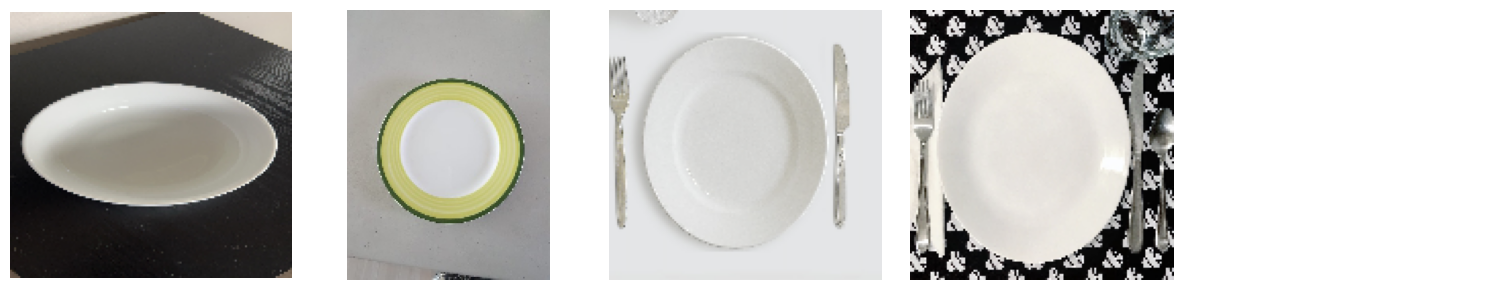

In [111]:
# Weird we have some images for which no keypoints are found, as expected, lets verify
# we also counted datapoints with <= keypoints to cull
print(outliers)
outlier_img = []

for i in outliers:
    outlier_img.append(combined[i])

show_some_images(outlier_img, max_cols=5, thumbnail_size=(128, 128), num = len(outlier_img))

In [112]:
# Note these images are some added to the original dataset from various Creative Commons archives and my own photographs
# Not sure why this is the case
# Lets remove any datapoints with 0 keypoints

# first we save Y as it is for our raw dataset comparison
Y_raw = copy.deepcopy(Y)

cleaned = False

# use while loop since indexes will change after every deletion
while (not cleaned):

    deleted_anything = False

    for index, i in enumerate(X):
        if i[1] is None:
            print(f"Deleting element at index {index} with keypoints: {X[index][0]} and descriptors: {X[index][1]}")
            del X[index]
            del Y[index]
            deleted_anything = True
            break
            
        if i[1] is not None:
            if len(i[1]) <= 3:
                print(f"Deleting element at index {index} with {len(X[index][0])} keypoints and {len(X[index][1])} descriptors ")
                del X[index]
                del Y[index]
                deleted_anything = True
                break

    if not deleted_anything:
        cleaned = True
            


Deleting element at index 95 with keypoints: () and descriptors: None
Deleting element at index 102 with 3 keypoints and 3 descriptors 
Deleting element at index 128 with keypoints: () and descriptors: None
Deleting element at index 176 with keypoints: () and descriptors: None


In [113]:
# Now lets check our data to make sure we deleted the points with 0 keypoints
shapes, outliers = keypoint_count(X)

Value: 12, Count: 2
Value: 21, Count: 1
Value: 24, Count: 1
Value: 32, Count: 1
Value: 34, Count: 1
Value: 35, Count: 1
Value: 37, Count: 1
Value: 39, Count: 1
Value: 41, Count: 1
Value: 44, Count: 1
Value: 46, Count: 1
Value: 52, Count: 2
Value: 60, Count: 1
Value: 64, Count: 1
Value: 67, Count: 1
Value: 68, Count: 1
Value: 69, Count: 1
Value: 71, Count: 1
Value: 86, Count: 2
Value: 87, Count: 1
Value: 89, Count: 1
Value: 90, Count: 1
Value: 95, Count: 1
Value: 101, Count: 1
Value: 106, Count: 2
Value: 107, Count: 2
Value: 109, Count: 1
Value: 111, Count: 1
Value: 116, Count: 1
Value: 118, Count: 1
Value: 121, Count: 1
Value: 125, Count: 1
Value: 126, Count: 2
Value: 128, Count: 1
Value: 130, Count: 1
Value: 133, Count: 1
Value: 134, Count: 1
Value: 135, Count: 1
Value: 136, Count: 2
Value: 137, Count: 1
Value: 141, Count: 1
Value: 142, Count: 1
Value: 143, Count: 1
Value: 145, Count: 3
Value: 147, Count: 1
Value: 148, Count: 1
Value: 150, Count: 1
Value: 151, Count: 1
Value: 152, Cou

In [114]:
# Lets look at our data points
print("\nThe 1st keypoint:")
print(X[73][0][13])
print(f"x: {X[73][0][13].pt[0]}, y: {X[73][0][13].pt[1]}")
print(f"")
print(f"\nThe 1st descriptor, with length {len(X[0][1][0])}:")
print(X[0][1][0])



The 1st keypoint:
< cv2.KeyPoint 0x13fe908a0>
x: 83.21037292480469, y: 185.50978088378906


The 1st descriptor, with length 128:
[ 37.   2.   0.   0.   0.   0.   0.   0. 195.  39.   0.   0.   0.   0.
   1.  19.  73.  19.   2.   1.   5.  10.  16.  26.  32.  13.   8.   2.
   2.   6.   4.   5.  51.   0.   0.   0.   0.   0.   0.   2. 195.   9.
   0.   1.   0.   1.   7. 117.  93.   5.   1.  22.  50.  34.  45.  79.
   2.   7.  10.  17.  42.  11.   5.   5.  52.   3.   0.   0.   0.   0.
   0.   0. 195. 106.   9.   5.   0.   0.   0.  12.  93.  53.  31. 114.
  45.   4.   2.   7.   3.  28.  10.  35.  22.   2.   1.   3.  29.   2.
   0.   0.   0.   0.   0.   0. 195.  66.   6.   1.   0.   0.   0.   3.
  64.  36.  35.  32.   3.   2.   2.   4.  12.  13.   6.  14.   2.   0.
   2.  18.]


In [ ]:
# Next we turn cv keypoint objects to lists

# We would also run into another problem, our CNN expects homogeneous matrices as input data 
#   in order to apply convolutional filters. But currently our shape for our sift data
#   is (total_images, 2, 1163, (6, 128))
#   Meaning that every image has 2 lists which both contain 1163 elements. But the
#   elments in list 1 are lists of length 8 (keypoint attributes)
#   and the elements in list 2 are np arrays of length 128 (keypoint descriptors)

# Solution: Perhaps not the most efficient approach but from past work with an SVM model
#   I learned that you can reshape data and retain much information even with extensive
#   padding, as long as the same algorithm is applied to every point, the model should
#   differentiate between real data and padding from point to point. I'm sure there are
#   more sophisticated approaches by collapsing all matrices into one with some fancy
#   linear algebra but padding will be good enough for this experiment
#   TODO: Find that sophisticated approach

X_list = []

for index, datapoint in enumerate(X):
    kp_as_lists = []
    for kp in datapoint[0]:
        kp_data = [
            kp.pt[0],
            kp.pt[1],
            kp.size,
            kp.response,
            kp.octave,
            kp.class_id,
            ]
        
        # we pad the list to length 128 to match the descriptors
        # pad with -1 which should be meaningless and repeated across all datapoints
        for i in range(122):
            kp_data.append(-1)
        kp_as_lists.append(kp_data)
    
    descriptors = copy.deepcopy(datapoint[1])
    X_list.append([kp_as_lists, descriptors])


In [116]:
# lets verify we turned our kp to lists by checking a point or two
print(f"Datapoint 1, Keypoint 1: {X_list[0][0][0]}")
print(f"Datapoint 1, Keypoint 1: [{X[0][0][0].pt[0]}, {X[0][0][0].pt[1]}, {X[0][0][0].size}, {X[0][0][0].response}, {X[0][0][0].octave}, {X[0][0][0].class_id}]")

print(f"Datapoint 73, Keypoint 13: {X_list[73][0][13]}")
print(f"Datapoint 73, Keypoint 13: [{X[73][0][13].pt[0]}, {X[73][0][13].pt[1]}, {X[73][0][13].size}, {X[73][0][13].response}, {X[73][0][13].octave}, {X[73][0][13].class_id}]")

Datapoint 1, Keypoint 1: [4.044646739959717, 72.91256713867188, 2.1872010231018066, 0.02335325814783573, 14287359, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Datapoint 1, Keypoint 1: [4.044646739959717, 72.91256713867188, 2.1872010231018066, 0.02335325814783573, 14287359, -1]
Datapoint 73, Keypoint 13: [83.21037292480469, 185.50978088378906, 2.209958791732788, 0.03264250606298447, 15008255, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

In [117]:
print(f"Image 0 has {len(X[0][0])} keypoints and {len(X[0][1])} descriptors")

Image 0 has 216 keypoints and 216 descriptors


In [118]:
# were going to want to pad our data to feed the CNN keypoints where each is all the same shape
# There are many approaches to this but I will do a simple one, 
#   pad the last keypoint repeatedly until we have the desired shape
# The desired shape will be that of the datapoint with the most SIFT keypoints

def pad_last(data, pad_size):

    for index, dp in enumerate(data):
        kp = dp[0] # keypoints
        dp[1] = dp[1].tolist()
        ds = dp[1] # descriptor lists
        kp_pad = dp[0][-1] # last keypoint
        ds_pad = dp[0][-1] # last descriptor

        if (ds is None or kp is None):
            print(f"Image {index} is None")
            exit(10)

        while (len(kp) < pad_size):

            if (len(kp) > pad_size):
                print(f"Something went wrong, length of keypoint list is {len(kp)}")
                exit(10)
            
            if (len(kp) != len(ds)):
                print(f"Something went wrong, length of keypoint list {len(kp)} does not match length of list of descriptor lists {len(ds)} for index {index}")
                exit(10)

            kp.append(kp_pad)
            ds.append(ds_pad)
        


In [119]:
# This is the number of keypoints that the datapoint with the most keypoints has
print(f"Max shape: {max(shapes)}")

Max shape: 1163


In [120]:
# now we pad the datapoints to the size of the largest and recheck it as before
# This time we are expecing all to be same size

X_padded = copy.deepcopy(X_list)

pad_last(X_padded, max(shapes))


shapes, outliers = keypoint_count(X_padded)


Value: 1163, Count: 788


In [121]:
# lets verify nothing went wrong with the padding
print(f"Padded Datapoint 1, Keypoint 1: {X_padded[0][0][0]}")
print(f"Datapoint 1, Keypoint 1: {X_list[0][0][0]}")


print(f"\nPadded Datapoint 73, Keypoint 13: {X_list[73][0][13]}")
print(f"Datapoint 73, Keypoint 13: {X_padded[73][0][13]}")

# lets check if our padding worked
print(f"\nWe know datapoint 1 only had {len(X_list[0][0])} keypoints")
print(f"So keypoint {len(X_list[0][0]) - 1} must match keypoint {max(shapes) - 1}")
print(f"Padded Datapoint 1, Keypoint {len(X_list[0][0]) - 1}: {X_padded[0][0][len(X_list[0][0]) - 1]}")
print(f"Padded Datapoint 1, Keypoint {max(shapes) - 1}: {X_padded[0][0][max(shapes) - 1]}")


Padded Datapoint 1, Keypoint 1: [4.044646739959717, 72.91256713867188, 2.1872010231018066, 0.02335325814783573, 14287359, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Datapoint 1, Keypoint 1: [4.044646739959717, 72.91256713867188, 2.1872010231018066, 0.02335325814783573, 14287359, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [129]:
# Lets check to make sure our data is homogeneous
# Numpy.shape will error out if its not, otherwise it will tell us the shape
np.shape(X_padded)

(788, 2, 1163, 128)

In [130]:
# Now we have another small problem, the raw images we want to compare against have odd shapes
# Lets try transforming them to gray scale

def convert_to_black_and_white(images):
    """
    Converts a list of image matrices to black and white (grayscale).
    
    Args:
        images (list of numpy.ndarray): List of image matrices.
        
    Returns:
        list of numpy.ndarray: List of grayscale images.
    """
    grayscale_images = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) if len(image.shape) == 3 else image for image in images]
    return grayscale_images


In [131]:
# Run the transform function
rs_bw_data = convert_to_black_and_white(resized_data)

In [ ]:
# Now we double check the shape, if error, this didn't work
# With my data, we can see that the output is 792 images each 278x348 pixels
np.shape(rs_bw_data)

(792, 278, 348)

In [123]:
# Now that we have cleaned, ran SIFT, and padded data, we save to pickle to load in the model training notebook
with open('data/train/processed/SIFT_data.pkl', 'wb') as f:
    pickle.dump(X_padded, f)

print("Saved")

Saved


In [133]:
# We also pickle our resized images to run a comparison tests against our SIFT data
with open('data/train/processed/resized_data.pkl', 'wb') as f:
    pickle.dump(rs_bw_data, f)

print("Saved")

Saved


In [125]:
# We also save the labels
with open('data/train/processed/SIFT_labels.pkl', 'wb') as f:
    pickle.dump(Y, f)

# Now that we have cleaned, ran SIFT, and padded data, we save to pickle to load in the model training notebook
with open('data/train/processed/resized_labels.pkl', 'wb') as f:
    pickle.dump(Y_raw, f)

print("Saved")

Saved
